# Retrieval Augumented Generation (RAG) inference

***This notebook works best with the `conda_python3` on the `ml.t3.large` instance***.

---

At this point our slide deck data is ingested into Amazon OpenSearch Service Serverless collection. We are now ready to talk to our slide deck using a large multimodal model. We are using the [LLaVA 1.5-7b](https://huggingface.co/anymodality/llava-v1.5-7b) for this purpose. LLaVA is an open-source chatbot trained by fine-tuning LLaMA/Vicuna on GPT-generated multimodal instruction-following data. It is an auto-regressive language model, based on the transformer architecture.

## Step 1. Setup

Install the required Python packages and import the relevant files.

In [32]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [158]:
import os
import io
import sys
import json
import glob
import boto3
import base64
import logging
import requests
import botocore
import numpy as np
import pandas as pd
import globals as g
from PIL import Image
from pathlib import Path
from typing import List, Dict
from IPython.display import Image
from utils import get_cfn_outputs
from urllib.parse import urlparse
from botocore.auth import SigV4Auth
from pandas.core.series import Series
from sagemaker import get_execution_role
from botocore.awsrequest import AWSRequest
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from sagemaker.huggingface.model import HuggingFaceModel, HuggingFacePredictor

In [36]:
!pygmentize globals.py

"""
Global variables used throughout the code.
"""
import os
import boto3
import sagemaker

# model deployment
HF_MODEL_ID = "anymodality/llava-v1.5-13b"
HF_MODEL_ID: str = "anymodality/llava-v1.5-7b"

HF_TASK: str = "question-answering"
TRANSFORMERS_VERSION: str = "4.28.1"
PYTORCH_VERSION: str = "2.0.0"
PYTHON_VERSION: str = "py310"

# S3 bucket strucutre, we use the default sagemaker bucket in the current region
BUCKET_NAME: str = sagemaker.Session().default_bucket()
BUCKET_PREFIX: str = "multimodal"
BUCKET_EMB_PREFIX: str = f"{BUCKET_PREFIX}/osi-embeddings-json"
BUCKET_IMG_PREFIX: str = f"{BUCKET_PREFIX}/img"

# Amazon Titan multimodal model
AWS_REGION: str = boto3.Session().region_name
FMC_URL: str = f"https://bedrock-runtime.{AWS_REGION}.amazonaws.com"
FMC_MODEL_ID: str = "amazon.titan-embed-image-v1"
ACCEPT_ENCODING: str = "application/json"
CONTENT_ENCODING: str = "application/json"

# model.tar.gz path in S3
S3_MODEL_URI: str = os.path.join("s3://", BUCKET_NAME, BUCKET_PREFIX, 

In [37]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

## Step 2. Create an OpenSearch client and SageMaker Predictor object

We create an OpenSearch client so that we can query the vector database for embeddings (slides) similar to the questions that we might want to ask of our slide deck and then we create a SageMaker [`Predictor`](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) to run inference using the LLaVA model given the slide we retrieved from OpenSearch.

Get the name of the OpenSearch Service Serverless collection endpoint and index name from the CloudFormation stack outputs.

In [38]:
outputs = get_cfn_outputs(g.CFN_STACK_NAME)
host = outputs['MultimodalCollectionEndpoint'].split('//')[1]
index_name = outputs['OpenSearchIndexName']
logger.info(f"opensearchhost={host}, index={index_name}")

[2024-01-07 04:17:13,487] p26314 {2210621458.py:4} INFO - opensearchhost=jcbl0nhke4fyxk2bfjz2.us-east-1.aoss.amazonaws.com, index=multimodalslidesindex


We use the OpenSearch client to create an index.

In [39]:
session = boto3.Session()
credentials = session.get_credentials()
auth = AWSV4SignerAuth(credentials, g.AWS_REGION, g.OS_SERVICE)

os_client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

[2024-01-07 04:17:53,594] p26314 {credentials.py:1075} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Now create the SageMaker Predictor for the LLaVA endpoint we deployed in the [`0_deploy_llava.ipynb`](./0_deploy_llava.ipynb) notebook.

In [40]:
endpoint_name = Path(g.ENDPOINT_FILENAME).read_text()
predictor = HuggingFacePredictor(endpoint_name)
logger.info(f"created predictor for the {endpoint_name} endpoint")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[2024-01-07 04:19:02,612] p26314 {1280433889.py:3} INFO - created predictor for the huggingface-pytorch-inference-2024-01-06-23-34-46-386 endpoint


## Step 3. Read for RAG

We now have all the pieces for RAG. Here is how we _talk to our slide deck_.

1. Convert the user question into embeddings using the Titan Multimodal Embeddings model.

1. Find the most similar slide (image) corresponding to the the embeddings (for the user question) from the vector database (OpenSearch Serverless).

1. Now ask LLaVA (via the SageMaker Endpoint) to answer the user question using the retrieved image for the most similar slide.

In [41]:
def get_text_embeddings(bedrock: botocore.client, image: str) -> np.ndarray:
    body = json.dumps(dict(inputText=image))
    try:
        response = bedrock.invoke_model(
            body=body, modelId=g.FMC_MODEL_ID, accept=g.ACCEPT_ENCODING, contentType=g.CONTENT_ENCODING
        )
        response_body = json.loads(response.get("body").read())
        embeddings = np.array([response_body.get("embedding")]).astype(np.float32)
    except Exception as e:
        logger.error(f"exception while text={text}, exception={e}")
        embeddings = None

    return embeddings

In [42]:
bedrock = boto3.client(service_name="bedrock-runtime", endpoint_url=g.FMC_URL)

Use the following prompt template to make sure that the model only answers from the slides (images).

In [152]:
prompt_template: str = """Pretend that you are a helpful assistant that answers questions about content in a slide deck. 
Using only the information in the provided slide image answer the following question.
If you do not find the answer in the image then say I did not find the answer to this question in the slide deck.

{question}
"""

A handy function for similarity search in the vector db

In [155]:
def find_similar_data(text_embeddings: np.ndarray) -> Dict:
    query = {
        "size": 1,
        "query": {
            "knn": {
                "vector_embedding": {
                    "vector": text_embeddings[0].tolist(),
                    "k": 1
                }
            }
        }
    }
    try:
        image_based_search_response = os_client.search(body=query, index=index_name)
        # remove the vector_embedding field for readability purposes, it was needed during
        # the similarity search (by the vector db), we do not need it any more.
        source = image_based_search_response['hits']['hits'][0]['_source'].pop('vector_embedding')
        logger.info(f"received response from OpenSearch, response={json.dumps(image_based_search_response, indent=2)}")
    except Exception as e:
        logger.error(f"error occured while querying OpenSearch index={index_name}, exception={e}")
        image_based_search_response = None
    return image_based_search_response

### Question 1

Create a prompt and convert it to embeddings.

In [176]:
question: str = "How does Inf2 compare in performance to comparable EC2 instances? I need numbers."
prompt = prompt_template.format(question=question)
text_embeddings = get_text_embeddings(bedrock, question)

Find the most similar slide from the vector db.

In [177]:
vector_db_response: Dict = find_similar_data(text_embeddings)

[2024-01-07 05:28:12,652] p26314 {base.py:259} INFO - POST https://jcbl0nhke4fyxk2bfjz2.us-east-1.aoss.amazonaws.com:443/multimodalslidesindex/_search [status:200 request:0.045s]
[2024-01-07 05:28:12,654] p26314 {2807163302.py:18} INFO - received response from OpenSearch, response={
  "took": 16,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 2,
      "relation": "eq"
    },
    "max_score": 0.51882845,
    "hits": [
      {
        "_index": "multimodalslidesindex",
        "_id": "1%3A0%3A0Kmp4IwBNjIfrCWbut-5",
        "_score": 0.51882845,
        "_source": {
          "image_path": "s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg",
          "metadata": {
            "model_id": "amazon.titan-embed-image-v1",
            "slide_description": "",
            "slide_filename": "https://d1.awsstatic.com/events/Summits/to

Retrieve the image path from the search results and provide it to LLaVA along with the user question.

[2024-01-07 05:28:12,663] p26314 {3260149686.py:2} INFO - going to answer the question="How does Inf2 compare in performance to comparable EC2 instances? I need numbers." using the image "s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg"


download: s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg


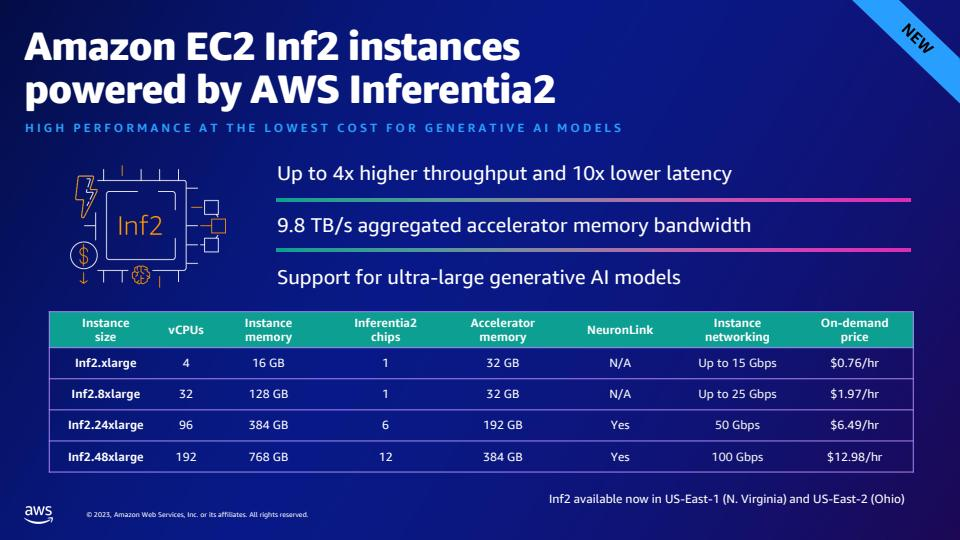

In [178]:
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
Image(filename=local_img_path) 

In [179]:
data = {
    "image" : s3_img_path,
    "question" : prompt,
    "temperature" : 0.1,
}
output = predictor.predict(data)
logger.info(f"Image={s3_img_path}\nQuestion: {question}\nAnswer: {output}\n\n")

[2024-01-07 05:28:15,650] p26314 {550040888.py:7} INFO - Image=s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_25.jpg
Question: How does Inf2 compare in performance to comparable EC2 instances? I need numbers.
Answer: According to the slide deck, Inf2 instances by AWS Inferentia2 offer up to 4x higher throughput and 10x lower latency compared to comparable EC2 instances.




### Question 2

[2024-01-07 05:27:48,023] p26314 {base.py:259} INFO - POST https://jcbl0nhke4fyxk2bfjz2.us-east-1.aoss.amazonaws.com:443/multimodalslidesindex/_search [status:200 request:0.077s]
[2024-01-07 05:27:48,025] p26314 {2807163302.py:18} INFO - received response from OpenSearch, response={
  "took": 31,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 2,
      "relation": "eq"
    },
    "max_score": 0.52241534,
    "hits": [
      {
        "_index": "multimodalslidesindex",
        "_id": "1%3A0%3A6amp4IwBNjIfrCWbut-5",
        "_score": 0.52241534,
        "_source": {
          "image_path": "s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_12.jpg",
          "metadata": {
            "model_id": "amazon.titan-embed-image-v1",
            "slide_description": "",
            "slide_filename": "https://d1.awsstatic.com/events/Summits/to

download: s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_12.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_12.jpg


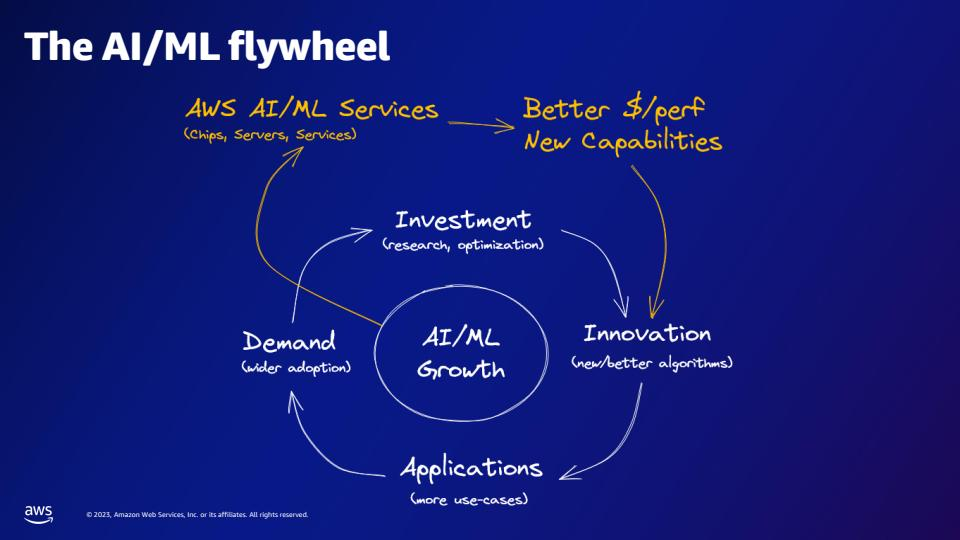

[2024-01-07 05:27:50,362] p26314 {2163136891.py:24} INFO - Image=s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_12.jpg
Question: As per the AI/ML flywheel, what do the AWS AI/ML services provide?
Answer: The AWS AI/ML services provide better $/perfer capabilities, new capabilities, and investment in innovation.




In [175]:
# create prompt and convert to embeddings
question: str = "As per the AI/ML flywheel, what do the AWS AI/ML services provide?"
prompt = prompt_template.format(question=question)
text_embeddings = get_text_embeddings(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embeddings)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask LLaVA
data = {
    "image" : s3_img_path,
    "question" : prompt,
    "temperature" : 0.1,
}
output = predictor.predict(data)
logger.info(f"Image={s3_img_path}\nQuestion: {question}\nAnswer: {output}\n\n")

### Question 3

How about a question that cannot be answered based on this slide deck? We want to confirm that while some slide image will be retrieved but the LLaVA model does not hallucinate and correctly says  "I do not know".

[2024-01-07 05:26:59,497] p26314 {base.py:259} INFO - POST https://jcbl0nhke4fyxk2bfjz2.us-east-1.aoss.amazonaws.com:443/multimodalslidesindex/_search [status:200 request:0.134s]
[2024-01-07 05:26:59,499] p26314 {2807163302.py:18} INFO - received response from OpenSearch, response={
  "took": 82,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 2,
      "relation": "eq"
    },
    "max_score": 0.4561107,
    "hits": [
      {
        "_index": "multimodalslidesindex",
        "_id": "1%3A0%3A2amp4IwBNjIfrCWbut-5",
        "_score": 0.4561107,
        "_source": {
          "image_path": "s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_9.jpg",
          "metadata": {
            "model_id": "amazon.titan-embed-image-v1",
            "slide_description": "",
            "slide_filename": "https://d1.awsstatic.com/events/Summits/torsu

download: s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_9.jpg to ./CMP301_TrainDeploy_E1_20230607_SPEdited_image_9.jpg


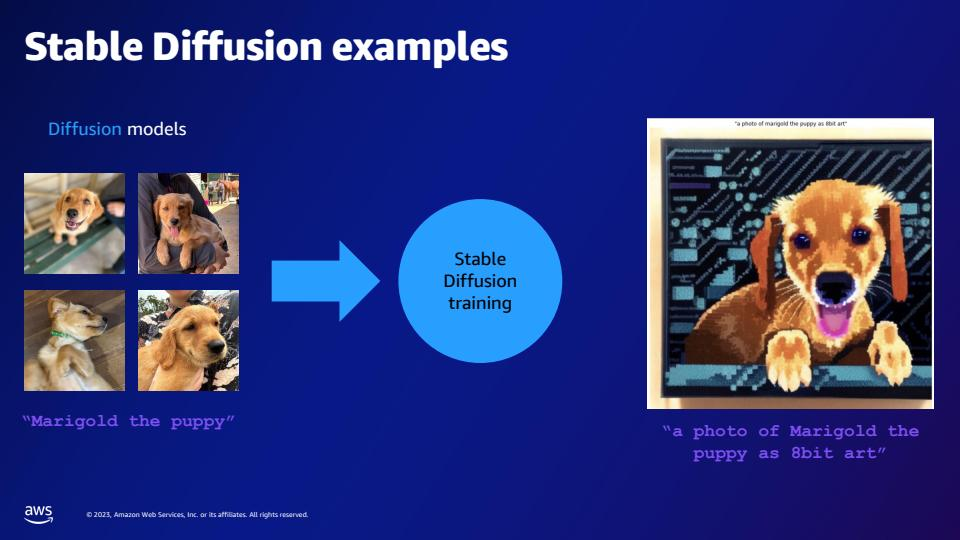

[2024-01-07 05:27:01,458] p26314 {3951696921.py:24} INFO - Image=s3://sagemaker-us-east-1-015469603702/multimodal/img/CMP301_TrainDeploy_E1_20230607_SPEdited_image_9.jpg
Question: What are quarks in particle physics?
Answer: I did not find the answer to this question in the slide deck.




In [173]:
# create prompt and convert to embeddings
question: str = "What are quarks in particle physics?"
prompt = prompt_template.format(question=question)
text_embeddings = get_text_embeddings(bedrock, question)

# vector db search
vector_db_response: Dict = find_similar_data(text_embeddings)

# download image for local notebook display
s3_img_path = vector_db_response.get('hits', {}).get('hits')[0].get('_source').get('image_path')
logger.info(f"going to answer the question=\"{question}\" using the image \"{s3_img_path}\"")

!aws s3 cp {s3_img_path} .
local_img_path = os.path.basename(s3_img_path)
display(Image(filename=local_img_path))

# Ask LLaVA
data = {
    "image" : s3_img_path,
    "question" : prompt,
    "temperature" : 0.1,
}
output = predictor.predict(data)
logger.info(f"Image={s3_img_path}\nQuestion: {question}\nAnswer: {output}\n\n")